### Libraries Importing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Data Importing

In [3]:
customers_df = pd.read_excel('E-commerce_data.xlsx', sheet_name='customers')
genders_df = pd.read_excel('E-commerce_data.xlsx', sheet_name='genders')
cities_df = pd.read_excel('E-commerce_data.xlsx', sheet_name='cities')
transactions_df = pd.read_excel('E-commerce_data.xlsx', sheet_name='transactions')
branches_df = pd.read_excel('E-commerce_data.xlsx', sheet_name='branches')
merchants_df = pd.read_excel('E-commerce_data.xlsx', sheet_name='merchants')
print(customers_df.head())
print(genders_df.head())
print(cities_df.head())
print(transactions_df.head())
print(branches_df.head())
print(merchants_df.head())

   customer_id  join_date  city_id  gender_id
0            1 2022-01-08        7          1
1            2 2023-05-02       20          2
2            3 2023-05-14       15          1
3            4 2022-11-25       11          2
4            5 2023-04-26        8          1
   gender_id gender_name
0          1        Male
1          2      Female
   city_id         city_name
0        1             Cairo
1        2        Alexandria
2        3              Giza
3        4  Shubra El-Kheima
4        5         Port Said
   transaction_id  customer_id transaction_date transaction_status  \
0               1          733       2024-05-11         subscribed   
1               2          631       2023-05-15             burned   
2               3          309       2022-11-13         subscribed   
3               4          695       2024-01-26         subscribed   
4               5          288       2022-10-12             burned   

  coupon_name  burn_date  branch_id  
0     uNY-568   

### Merging Dataframes

In [4]:
#Merging customers with genders dataframes
df= customers_df.merge(genders_df, on='gender_id', how = 'left')
#merging the cities dataframe
df= df.merge(cities_df,on='city_id', how = 'left')
#merging transactions dataframe
df=df.merge(transactions_df, on = 'customer_id', how = 'right')
#merging branches dataframe
df= df.merge(branches_df, on = 'branch_id', how= 'left')
#merging merchant dataframe
df = df.merge(merchants_df, on = 'merchant_id', how='left')

df.head()

,customer_id,join_date,city_id,gender_id,gender_name,city_name,transaction_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name
0,733,2023-05-16,15,2,Female,Aswan,1,2024-05-11,subscribed,uNY-568,NaT,7,7,Berry-Anderson
1,631,2022-10-10,14,2,Female,Damietta,2,2023-05-15,burned,kBx-219,2023-06-04,5,9,"Campbell, Shaffer and Martinez"
2,309,2022-05-30,2,1,Male,Alexandria,3,2022-11-13,subscribed,PLG-122,NaT,7,7,Berry-Anderson
3,695,2023-11-27,15,2,Female,Aswan,4,2024-01-26,subscribed,Wzf-897,NaT,2,18,Lewis LLC
4,288,2021-09-04,14,1,Male,Damietta,5,2022-10-12,burned,qGb-428,2022-11-20,6,15,Butler-Gomez


In [5]:
df.shape

(5000, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         5000 non-null   int64         
 1   join_date           5000 non-null   datetime64[ns]
 2   city_id             5000 non-null   int64         
 3   gender_id           5000 non-null   int64         
 4   gender_name         5000 non-null   object        
 5   city_name           5000 non-null   object        
 6   transaction_id      5000 non-null   int64         
 7   transaction_date    5000 non-null   datetime64[ns]
 8   transaction_status  5000 non-null   object        
 9   coupon_name         5000 non-null   object        
 10  burn_date           2516 non-null   datetime64[ns]
 11  branch_id           5000 non-null   int64         
 12  merchant_id         5000 non-null   int64         
 13  merchant_name       5000 non-null   object      

### Data cleaning

In [7]:
#checking the data types
df.dtypes

customer_id                    int64
join_date             datetime64[ns]
city_id                        int64
gender_id                      int64
gender_name                   object
city_name                     object
transaction_id                 int64
transaction_date      datetime64[ns]
transaction_status            object
coupon_name                   object
burn_date             datetime64[ns]
branch_id                      int64
merchant_id                    int64
merchant_name                 object
dtype: object

In [8]:
#checking data for duplicates
df.duplicated().sum()

0

In [9]:
#checking the missing values
df.isna().sum()/len(df)

customer_id           0.0000
join_date             0.0000
city_id               0.0000
gender_id             0.0000
gender_name           0.0000
city_name             0.0000
transaction_id        0.0000
transaction_date      0.0000
transaction_status    0.0000
coupon_name           0.0000
burn_date             0.4968
branch_id             0.0000
merchant_id           0.0000
merchant_name         0.0000
dtype: float64

`burn_date` has ~ 50% of its values as nulls, so we can't drop the missing values and since it provides important information that could help improve the model's performance, we cannot drop it.
so we will overcome this issue by replacing the null values with a specific date (e.g., "2099-12-31" as a placeholder).

In [10]:
df['burn_date'].fillna('2099-12-31', inplace=True)

In [11]:
df['burn_date'].isna().sum()

0

### Create Customer-Level Metrics

instead of dealing with dataset at a transaction level (which means each observation is a transaction), we will aggregate new features at customer-level.

In [12]:
# Aggregate data to customer level
customer_df = df.groupby('customer_id').agg({
    'join_date': 'first',                  
    'transaction_date': ['max', 'count'],  
    'transaction_status': lambda x: (x == 'completed').mean(),  
    'burn_date': lambda x: (x != '2099-12-31').sum(),
}).reset_index()

# Rename columns
customer_df.columns = [
    'customer_id', 
    'join_date', 
    'last_transaction_date', 
    'total_transactions', 
    'success_rate', 
    'coupons_used'
]

# Calculate tenure (days since joining)
customer_df['tenure_days'] = (customer_df['last_transaction_date'] - customer_df['join_date']).dt.days

# Calculate recency (days since last transaction)
customer_df['recency_days'] = (pd.Timestamp.now() - customer_df['last_transaction_date']).dt.days

# Calculate coupon usage rate
customer_df['coupon_usage_rate'] = customer_df['coupons_used'] / customer_df['total_transactions']

# Drop datetime columns (no longer needed)
customer_df = customer_df.drop(columns=['join_date', 'last_transaction_date'])

In [13]:
customer_df.head()

,customer_id,total_transactions,success_rate,coupons_used,tenure_days,recency_days,coupon_usage_rate
0,1,7,0.0,3,869,282,0.428571
1,2,3,0.0,1,172,500,0.333333
2,3,5,0.0,1,418,242,0.200000
3,4,1,0.0,0,51,779,0.000000
4,5,4,0.0,3,433,245,0.750000


### Features scaling

In [14]:
features_to_scale = customer_df[[
    'total_transactions', 
    'recency_days', 
    'tenure_days', 
    'success_rate', 
    'coupon_usage_rate'
]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

### Determine Number of Clusters


#### Elbow Method

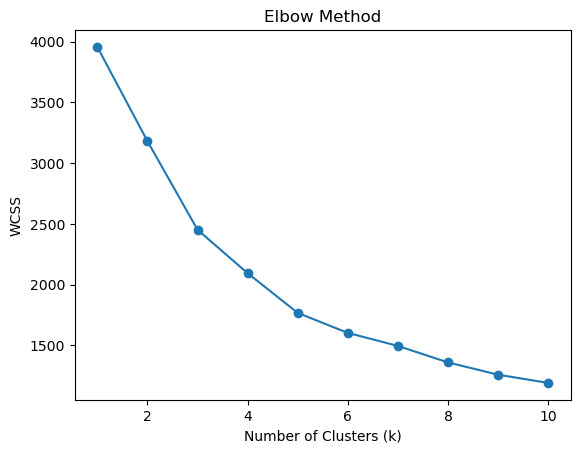

In [16]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

#### Silhouette Analysis

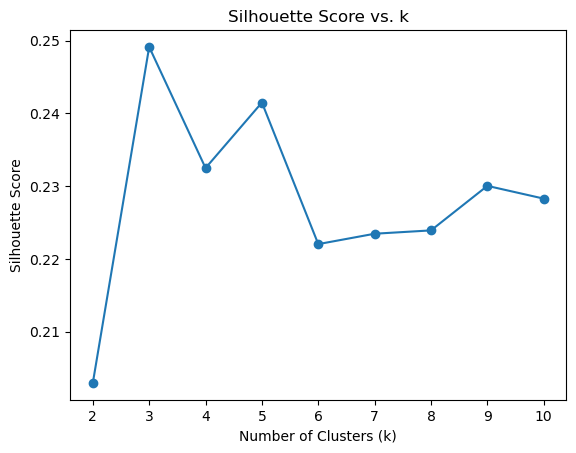

In [17]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')
plt.show()

### Train Model

In [18]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['cluster'] = kmeans.fit_predict(scaled_features)

In [19]:
cluster_summary = customer_df.groupby('cluster').agg({
    'total_transactions': 'mean',
    'recency_days': 'mean',
    'success_rate': 'mean',
    'coupon_usage_rate': 'mean',
}).reset_index()

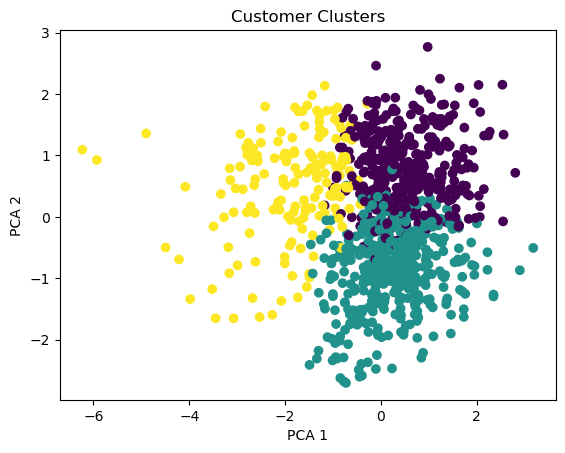

In [20]:
# Reduce to 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Plot
plt.scatter(
    pca_features[:, 0], pca_features[:, 1],
    c=customer_df['cluster'], cmap='viridis'
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Customer Clusters')
plt.show()

##### cluster 0(Yellow):

- High Engagement: Frequent purchases (high transactions) and recent activity (low recency).

- Moderate Coupon Reliance: Use coupons occasionally but are not fully dependent on them.

**Strategy**:

- Reward loyalty with exclusive offers or early access to new products.

- Upsell premium products (they’re likely to spend more).

##### Cluster 1 (Green):

- Declining Engagement: Haven’t purchased recently (high recency) and show moderate historical activity.

- Coupon-Averse: Rarely use discounts.

**Strategy**:

- Re-engage with personalized reactivation campaigns (e.g., "We miss you!" discounts).

- Investigate churn reasons (e.g., survey feedback).

##### Cluster 2  (Purple):

- Low Spend: Infrequent purchases (low transactions) but somewhat recent activity (moderate recency).

- Coupon Reliant: Highly dependent on discounts to make purchases.

**Strategy**:

- Target with time-sensitive coupon offers.

- Bundle deals to increase basket size (e.g., "Buy 2, get 1 free").